# fbprophet 모델을 활용한 인공지능 비트 트레이더 경진대회 베이스라인 코드

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install statsmodels==0.11.1
# !pip install fbprophet

# 1. Library Import

In [3]:
!pip install plotly

In [4]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import datetime
from plotly import tools 
import plotly.offline as offline 
import plotly.graph_objs as go 
warnings.filterwarnings("ignore")

# 2. 데이터 불러오기

## 1) read_csv

In [5]:
data_path = os.getenv('HOME') + '/ModuWay/data' # 경로 다름! 변경해줘야함
# data_path = os.getenv('HOME') + '/ModuWay/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

* sample_id : 개별 샘플의 인덱스
* time : x_df는 0분 ~ 1379분, y_df는 0분 ~ 119분의 값을 갖습니다. 동일한 샘플 내 시간 정보
* coin_index : 10가지 종류의 코인에 대한 비식별화 인덱스 (0 ~9)
* open : open price
* high : high price
* low : low price
* close : close price
* volume : 거래량
* quote_av : quote asset volume
* trades : 거래 건 수
* tb_base_av : taker buy base asset volume
* tb_quote_av : taker buy quote asset volume

In [6]:
train_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
10159555,7361,1375,8,1.000668,1.001669,1.000626,1.001502,9.180907e+00,2203.059082,2.245034,6.229020e+00,1494.727417
10159556,7361,1376,8,1.001627,1.001920,1.000960,1.001294,7.963097e+00,1911.151611,2.211651,3.056139e+00,733.490601
10159557,7361,1377,8,1.001294,1.001461,1.000584,1.000668,3.849893e+00,923.610718,1.260224,2.284546e+00,548.042297
10159558,7361,1378,8,1.000709,1.000751,1.000042,1.000042,1.337402e+00,320.624756,0.826239,5.164965e-01,123.819839


In [7]:
sma7 = pd.DataFrame(train_x_df.groupby(train_x_df['sample_id'])['close'].rolling(window = 7, min_periods=1).mean())
sma7

close
sample_id                   
0         0         1.010004
          1         1.009906
          2         1.010004
          3         1.010298
          4         1.010279
...                      ...
7361      10159555  0.999350
          10159556  0.999815
          10159557  1.000101
          10159558  1.000364
          10159559  1.000656

[10159560 rows x 1 columns]

In [8]:
train_x_df.loc[:,'sma7'] = sma7['close'].values

In [9]:
sma25 = pd.DataFrame(train_x_df.groupby(train_x_df['sample_id'])['close'].rolling(window = 25, min_periods=1).mean())
sma25

close
sample_id                   
0         0         1.010004
          1         1.009906
          2         1.010004
          3         1.010298
          4         1.010279
...                      ...
7361      10159555  0.998212
          10159556  0.998289
          10159557  0.998314
          10159558  0.998307
          10159559  0.998346

[10159560 rows x 1 columns]

In [10]:
train_x_df.loc[:,'sma25'] = sma25['close'].values

In [11]:
# train_x_df에 macdo 지표 추가
train_x_df['ma_12'] = pd.DataFrame(train_x_df.groupby(train_x_df['sample_id'])['close'].transform(lambda x: x.ewm(span=12, min_periods=1).mean()))
train_x_df['ma_26'] = pd.DataFrame(train_x_df.groupby(train_x_df['sample_id'])['close'].transform(lambda x: x.ewm(span=26, min_periods=1).mean()))
train_x_df['macd'] = train_x_df['ma_12'] - train_x_df['ma_26'] # MACD 
train_x_df['macds'] = pd.DataFrame(train_x_df.groupby(train_x_df['sample_id'])['macd'].transform(lambda x: x.ewm(span=9, min_periods=1).mean()))# Signal 
train_x_df['macdo'] = train_x_df['macd'] - train_x_df['macds'] # Oscillator 

In [12]:
train_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594,1.010004,1.010004,1.010004,1.010004,0.000000,0.000000,0.000000
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000,1.009906,1.009906,1.009898,1.009902,-0.000004,-0.000002,-0.000002
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808,1.010004,1.010004,1.010016,1.010009,0.000007,0.000001,0.000005
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875,1.010298,1.010298,1.010383,1.010337,0.000047,0.000017,0.000030
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000,1.010279,1.010279,1.010334,1.010305,0.000029,0.000020,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10159555,7361,1375,8,1.000668,1.001669,1.000626,1.001502,9.180907e+00,2203.059082,2.245034,6.229020e+00,1494.727417,0.999350,0.998212,0.998893,0.998314,0.000580,0.000110,0.000470
10159556,7361,1376,8,1.001627,1.001920,1.000960,1.001294,7.963097e+00,1911.151611,2.211651,3.056139e+00,733.490601,0.999815,0.998289,0.999263,0.998534,0.000728,0.000233,0.000495
10159557,7361,1377,8,1.001294,1.001461,1.000584,1.000668,3.849893e+00,923.610718,1.260224,2.284546e+00,548.042297,1.000101,0.998314,0.999479,0.998692,0.000786,0.000344,0.000442
10159558,7361,1378,8,1.000709,1.000751,1.000042,1.000042,1.337402e+00,320.624756,0.826239,5.164965e-01,123.819839,1.000364,0.998307,0.999565,0.998792,0.000773,0.000430,0.000343


In [13]:
train_y_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,42356.179688,137.308746,8.305119e+05,42356.179688
1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,27140.638672,294.233032,4.882738e+05,24909.861328
2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,26100.681641,58.846603,5.113770e+05,26100.681641
3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,57929.410156,137.308746,1.095514e+06,55921.156250
4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,295872.343750,666.928162,9.911239e+05,50528.589844
...,...,...,...,...,...,...,...,...,...,...,...,...
883435,7361,115,8,1.007303,1.007845,1.007261,1.007720,2.843995e+00,686.734558,0.792856,1.373841e+00,331.730499
883436,7361,116,8,1.007678,1.008847,1.007678,1.008471,2.577599e+00,622.798462,0.884660,1.638966e+00,396.005463
883437,7361,117,8,1.008513,1.009014,1.008304,1.008805,4.579865e+00,1106.928345,1.210149,1.735705e+00,419.485596
883438,7361,118,8,1.008680,1.009222,1.008680,1.009222,1.065129e+00,257.542755,0.525789,4.348240e-01,105.134232


In [14]:
sma7 = pd.DataFrame(train_y_df.groupby(train_y_df['sample_id'])['close'].rolling(window = 7, min_periods=1).mean())
sma7

close
sample_id                 
0         0       1.000588
          1       1.000883
          2       1.000981
          3       1.001079
          4       1.000902
...                    ...
7361      883435  1.006426
          883436  1.006850
          883437  1.007231
          883438  1.007750
          883439  1.008042

[883440 rows x 1 columns]

In [15]:
train_y_df.loc[:,'sma7'] = sma7['close'].values

In [16]:
sma25 = pd.DataFrame(train_y_df.groupby(train_y_df['sample_id'])['close'].rolling(window = 25, min_periods=1).mean())
sma25

close
sample_id                 
0         0       1.000588
          1       1.000883
          2       1.000981
          3       1.001079
          4       1.000902
...                    ...
7361      883435  1.006216
          883436  1.006291
          883437  1.006360
          883438  1.006446
          883439  1.006500

[883440 rows x 1 columns]

In [17]:
train_y_df.loc[:,'sma25'] = sma25['close'].values

In [18]:
# train_y_df macdo 지표 추가
train_y_df['ma_12'] = pd.DataFrame(train_y_df.groupby(train_y_df['sample_id'])['close'].transform(lambda x: x.ewm(span=12, min_periods=1).mean()))
train_y_df['ma_26'] = pd.DataFrame(train_y_df.groupby(train_y_df['sample_id'])['close'].transform(lambda x: x.ewm(span=26, min_periods=1).mean()))
train_y_df['macd'] = train_y_df['ma_12'] - train_y_df['ma_26'] # MACD 
train_y_df['macds'] = pd.DataFrame(train_y_df.groupby(train_x_df['sample_id'])['macd'].transform(lambda x: x.ewm(span=9, min_periods=1).mean()))# Signal 
train_y_df['macdo'] = train_y_df['macd'] - train_y_df['macds'] # Oscillator 

In [19]:
train_y_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,42356.179688,137.308746,8.305119e+05,42356.179688,1.000588,1.000588,1.000588,1.000588,0.000000,0.000000,0.000000
1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,27140.638672,294.233032,4.882738e+05,24909.861328,1.000883,1.000883,1.000907,1.000894,0.000013,0.000007,0.000006
2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,26100.681641,58.846603,5.113770e+05,26100.681641,1.000981,1.000981,1.001012,1.000996,0.000017,0.000011,0.000006
3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,57929.410156,137.308746,1.095514e+06,55921.156250,1.001079,1.001079,1.001126,1.001101,0.000025,0.000016,0.000009
4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,295872.343750,666.928162,9.911239e+05,50528.589844,1.000902,1.000902,1.000874,1.000891,-0.000018,0.000006,-0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883435,7361,115,8,1.007303,1.007845,1.007261,1.007720,2.843995e+00,686.734558,0.792856,1.373841e+00,331.730499,1.006426,1.006216,1.006404,1.006539,-0.000135,-0.000435,0.000300
883436,7361,116,8,1.007678,1.008847,1.007678,1.008471,2.577599e+00,622.798462,0.884660,1.638966e+00,396.005463,1.006850,1.006291,1.006722,1.006682,0.000040,-0.000340,0.000380
883437,7361,117,8,1.008513,1.009014,1.008304,1.008805,4.579865e+00,1106.928345,1.210149,1.735705e+00,419.485596,1.007231,1.006360,1.007043,1.006839,0.000203,-0.000231,0.000435
883438,7361,118,8,1.008680,1.009222,1.008680,1.009222,1.065129e+00,257.542755,0.525789,4.348240e-01,105.134232,1.007750,1.006446,1.007378,1.007016,0.000362,-0.000113,0.000475


In [20]:
test_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.003541,1.007110,1.003541,1.006090,486928.968750,182543.687500,332.671570,287449.968750,107758.375000
1,0,1,7,1.006117,1.006331,1.004829,1.005634,824485.375000,309019.750000,407.790955,560290.250000,210005.125000
2,0,2,7,1.005929,1.005983,1.004266,1.005366,478614.562500,179301.843750,276.332031,214270.265625,80283.554688
3,0,3,7,1.005044,1.005956,1.004910,1.005795,334366.843750,125305.117188,166.335785,56401.246094,21135.490234
4,0,4,7,1.005580,1.006466,1.005285,1.005929,560916.687500,210316.796875,303.160370,138711.703125,52010.964844
...,...,...,...,...,...,...,...,...,...,...,...,...
730015,528,1375,5,1.001805,1.001805,0.998797,0.998797,583600.875000,77517.406250,473.898010,9092.824219,1210.823120
730016,528,1376,5,0.998571,1.001730,0.996690,1.001730,688827.312500,91420.523438,503.986786,289617.906250,38465.292969
730017,528,1377,5,0.999323,1.003009,0.997367,1.002934,417688.437500,55624.304688,353.542969,291073.437500,38773.152344
730018,528,1378,5,1.000903,1.000903,0.999774,0.999925,91273.515625,12139.500000,120.355049,0.000000,0.000000


In [21]:
sma7 = pd.DataFrame(test_x_df.groupby(test_x_df['sample_id'])['close'].rolling(window = 7, min_periods=1).mean())
sma7

close
sample_id                 
0         0       1.006090
          1       1.005862
          2       1.005697
          3       1.005721
          4       1.005763
...                    ...
528       730015  0.997496
          730016  0.998205
          730017  0.999097
          730018  0.999549
          730019  0.999936

[730020 rows x 1 columns]

In [22]:
test_x_df.loc[:,'sma7'] = sma7['close'].values

In [23]:
sma25 = pd.DataFrame(test_x_df.groupby(test_x_df['sample_id'])['close'].rolling(window = 25, min_periods=1).mean())
sma25

close
sample_id                 
0         0       1.006090
          1       1.005862
          2       1.005697
          3       1.005721
          4       1.005763
...                    ...
528       730015  0.993994
          730016  0.994548
          730017  0.995099
          730018  0.995496
          730019  0.995824

[730020 rows x 1 columns]

In [24]:
test_x_df.loc[:,'sma25'] = sma25['close'].values

In [25]:
test_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma7,sma25
0,0,0,7,1.003541,1.007110,1.003541,1.006090,486928.968750,182543.687500,332.671570,287449.968750,107758.375000,1.006090,1.006090
1,0,1,7,1.006117,1.006331,1.004829,1.005634,824485.375000,309019.750000,407.790955,560290.250000,210005.125000,1.005862,1.005862
2,0,2,7,1.005929,1.005983,1.004266,1.005366,478614.562500,179301.843750,276.332031,214270.265625,80283.554688,1.005697,1.005697
3,0,3,7,1.005044,1.005956,1.004910,1.005795,334366.843750,125305.117188,166.335785,56401.246094,21135.490234,1.005721,1.005721
4,0,4,7,1.005580,1.006466,1.005285,1.005929,560916.687500,210316.796875,303.160370,138711.703125,52010.964844,1.005763,1.005763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730015,528,1375,5,1.001805,1.001805,0.998797,0.998797,583600.875000,77517.406250,473.898010,9092.824219,1210.823120,0.997496,0.993994
730016,528,1376,5,0.998571,1.001730,0.996690,1.001730,688827.312500,91420.523438,503.986786,289617.906250,38465.292969,0.998205,0.994548
730017,528,1377,5,0.999323,1.003009,0.997367,1.002934,417688.437500,55624.304688,353.542969,291073.437500,38773.152344,0.999097,0.995099
730018,528,1378,5,1.000903,1.000903,0.999774,0.999925,91273.515625,12139.500000,120.355049,0.000000,0.000000,0.999549,0.995496


In [26]:
# test_x_df macdo 지표 추가
test_x_df['ma_12'] = pd.DataFrame(test_x_df.groupby(test_x_df['sample_id'])['close'].transform(lambda x: x.ewm(span=12, min_periods=1).mean()))
test_x_df['ma_26'] = pd.DataFrame(test_x_df.groupby(test_x_df['sample_id'])['close'].transform(lambda x: x.ewm(span=26, min_periods=1).mean()))
test_x_df['macd'] = test_x_df['ma_12'] - test_x_df['ma_26'] # MACD 
test_x_df['macds'] = pd.DataFrame(test_x_df.groupby(test_x_df['sample_id'])['macd'].transform(lambda x: x.ewm(span=9, min_periods=1).mean()))# Signal 
test_x_df['macdo'] = test_x_df['macd'] - test_x_df['macds'] # Oscillator 

In [27]:
test_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,sma7,sma25,ma_12,ma_26,macd,macds,macdo
0,0,0,7,1.003541,1.007110,1.003541,1.006090,486928.968750,182543.687500,332.671570,287449.968750,107758.375000,1.006090,1.006090,1.006090,1.006090,0.000000,0.000000,0.000000
1,0,1,7,1.006117,1.006331,1.004829,1.005634,824485.375000,309019.750000,407.790955,560290.250000,210005.125000,1.005862,1.005862,1.005843,1.005853,-0.000010,-0.000006,-0.000005
2,0,2,7,1.005929,1.005983,1.004266,1.005366,478614.562500,179301.843750,276.332031,214270.265625,80283.554688,1.005697,1.005697,1.005657,1.005678,-0.000021,-0.000012,-0.000009
3,0,3,7,1.005044,1.005956,1.004910,1.005795,334366.843750,125305.117188,166.335785,56401.246094,21135.490234,1.005721,1.005721,1.005700,1.005711,-0.000010,-0.000012,0.000001
4,0,4,7,1.005580,1.006466,1.005285,1.005929,560916.687500,210316.796875,303.160370,138711.703125,52010.964844,1.005763,1.005763,1.005762,1.005761,0.000001,-0.000008,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730015,528,1375,5,1.001805,1.001805,0.998797,0.998797,583600.875000,77517.406250,473.898010,9092.824219,1210.823120,0.997496,0.993994,0.996444,0.994596,0.001849,0.001540,0.000309
730016,528,1376,5,0.998571,1.001730,0.996690,1.001730,688827.312500,91420.523438,503.986786,289617.906250,38465.292969,0.998205,0.994548,0.997257,0.995124,0.002133,0.001659,0.000475
730017,528,1377,5,0.999323,1.003009,0.997367,1.002934,417688.437500,55624.304688,353.542969,291073.437500,38773.152344,0.999097,0.995099,0.998131,0.995702,0.002428,0.001813,0.000616
730018,528,1378,5,1.000903,1.000903,0.999774,0.999925,91273.515625,12139.500000,120.355049,0.000000,0.000000,0.999549,0.995496,0.998407,0.996015,0.002391,0.001928,0.000463


In [28]:
# train_x_macd_df, train_y_macd_df, test_x_macd_df 저장
train_x_df.to_csv(data_path + '/train_x_macd_df.csv')
train_y_df.to_csv(data_path + '/train_y_macd_df.csv')
test_x_df.to_csv(data_path + '/test_x_macd_df.csv')

In [69]:
train_x_macd_df = pd.read_csv(data_path  + "/train_x_macd_df.csv")
train_y_macd_df = pd.read_csv(data_path  + "/train_y_macd_df.csv")
test_x_macd_df = pd.read_csv(data_path  + "/test_x_macd_df.csv")

## 2) numpy arrary로 변환하기

In [30]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [31]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [32]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 17)
train_y_array (7362, 120, 17)
test_x_array (529, 1380, 17)



## MACD 시각화 

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

In [ ]:
idx = 1030

In [70]:
index = train_x_df[train_x_df['sample_id']==idx].time.tolist()
type(index), len(index)

(list, 1380)

In [71]:
# loc 쓰기 귀찮아서 데이터 프레임으로.. 그냥 .. 때려..넣기? => 나중에 수정
sample_x_df = pd.DataFrame()
sample_x_df = train_x_df[['sample_id','sma7', 'sma25','macd','macdo','macds']]
sample_x_df.head()

,sample_id,sma7,sma25,macd,macdo,macds
0,0,1.010004,1.010004,0.000000,0.000000,0.000000
1,0,1.009906,1.009906,-0.000004,-0.000002,-0.000002
2,0,1.010004,1.010004,0.000007,0.000005,0.000001
3,0,1.010298,1.010298,0.000047,0.000030,0.000017
4,0,1.010279,1.010279,0.000029,0.000008,0.000020


In [72]:
sma7_lst = sample_x_df['sma7'].loc[sample_x_df['sample_id']==idx].tolist()
sma25_lst = sample_x_df['sma25'].loc[sample_x_df['sample_id']==idx].tolist()

In [73]:
print(len(sma25_lst) == len(sma7_lst)) # 차원 일치 여부 확인 
print(type(index) == type(sma7_lst)) # 형 일치 여부 확인 

True
True


In [74]:
index[0:2], sma7_lst[0:2] # 값 확인

([0, 1], [1.0661075115203935, 1.0664364099502603])

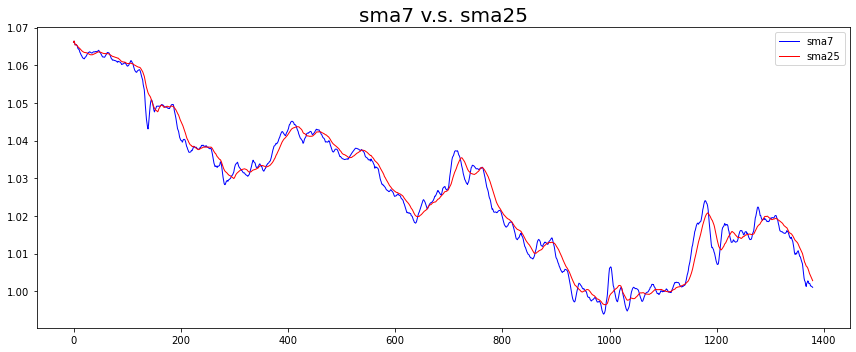

In [75]:
# Main chart - SMA_7 and SMA_25
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('sma7 v.s. sma25', fontsize=20)

ax.plot(index, sma7_lst, 'b', lw=1, label='sma7')
ax.plot(index, sma25_lst, 'r', lw=1, label='sma25')
ax.legend(loc='best')

fig.tight_layout()

In [76]:
macd_lst = sample_x_df['macd'].loc[sample_x_df['sample_id']==idx].tolist()
macds_lst = sample_x_df['macds'].loc[sample_x_df['sample_id']==idx].tolist()

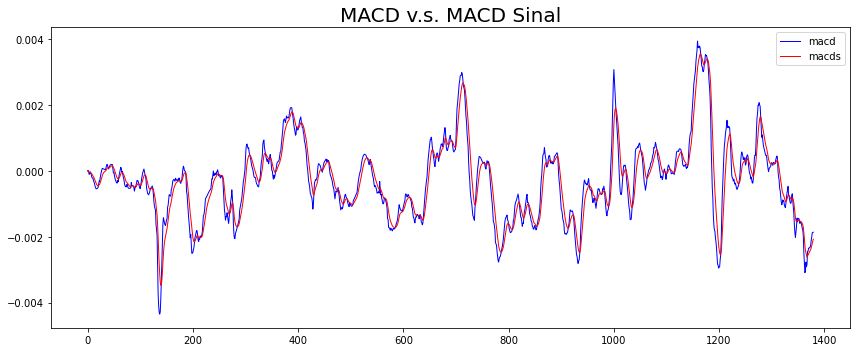

In [77]:
# index chart - MACD and MACDs
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('MACD v.s. MACD Sinal', fontsize=20)

ax.plot(index, macd_lst, 'b', lw=1, label='macd')
ax.plot(index, macds_lst, 'r', lw=1, label='macds')
ax.legend(loc='best')

fig.tight_layout()

In [78]:
macdo_lst = sample_x_df['macdo'].loc[sample_x_df['sample_id']==idx].tolist()

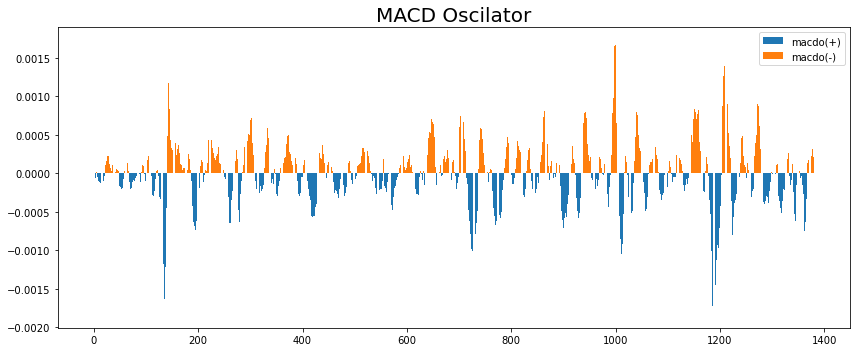

In [79]:
# index chart - MACDo
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('MACD Oscilator', fontsize=20)

ax.bar(index, [0 if i > 0 else i for i in macdo_lst], lw=1, label='macdo(+)')
ax.bar(index, [0 if i < 0 else i for i in macdo_lst], lw=1, label='macdo(-)')
ax.legend(loc='best')

fig.tight_layout()